### 資料載入
使用下面的程式碼載入資料:

In [ ]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np 

linreg = LinearRegression().fit(X_train,Y_train)
y_pred = linreg.predict(X_test)

RMSE = (np.mean((Y_test - y_pred)**2))**0.5
print(f'RMSE = {RMSE}')
print(f'前五個特徵的參數:{linreg.coef_[:5]}')

RMSE = 9.510160684544399
前五個特徵的參數:[ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


### Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [ ]:
import torch
from torch.utils import data
import torch.nn as nn
import matplotlib.pyplot as plt

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, Xnp, Ynp):
        'Initialization, passing Xnp and Ynp'
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
  def __len__(self):
        'Denotes the total number of samples'
        return self.nobs
  def __getitem__(self, index):
        'Generates one sample of data'        
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y
    
#y_train is a pandas.core.series.Series    
trainset = Dataset(X_train, Y_train)   
subtrainset = Dataset(X_subtrain,Y_subtrain)
validset = Dataset(X_valid,Y_valid)
testset = Dataset(X_test, Y_test)

In [ ]:
trainloader = data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=4)
subtrainloader = data.DataLoader(subtrainset, batch_size=1000, shuffle=True, num_workers=4)
validloader = data.DataLoader(validset, batch_size=1000, shuffle=True, num_workers=4)
testloader = data.DataLoader(testset, batch_size=1000, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP,self).__init__()
        self.patience = 5000
        self.epoch = 100
        self.calc_rmse_intvls = 100
        self.best_step_count = None
        self.best_loss = np.inf
        self.best_model = None
        self.sse = nn.MSELoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='mean')
        self.train_rmse_lst = []
        self.valid_rmse_lst = []
        
    def net(self,D_in,D_out,H,device,dropout = False):
        if dropout:
            model = nn.Sequential(
                nn.Linear(D_in,H),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(H,H),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(H,H),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(H,H),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(H,D_out)
                    )
        else :
            model = nn.Sequential(
                            nn.Linear(D_in,H),
                            nn.ReLU(),
                            nn.Linear(H,H),
                            nn.ReLU(),
                            nn.Linear(H,H),
                            nn.ReLU(),
                            nn.Linear(H,H),
                            nn.ReLU(),
                            nn.Linear(H,D_out)
                                )
        model = model.float()
        self.model = model.to(device)
        return self.model 
        
    def train(self,device,optimizer,verbose=True):
        step_count = 0
        total_loss = 0
        for epoch_idx in range(self.epoch):
            for batch_idx, (inputs, targets) in enumerate(subtrainloader):
                targets = targets.reshape((-1, 1))
                self.model.train()
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                step_count += 1
                outputs = self.model(inputs)
                loss_SSE = self.sse(outputs, targets) 
                loss_MSE = self.mse(outputs,targets)
                loss_SSE.backward()
                optimizer.step()
                total_loss += loss_MSE
                if step_count % self.calc_rmse_intvls == 0:
                    rmse_train = ((total_loss/step_count)**0.5).cpu().detach().numpy()
                    rmse_valid =self.calc_rmse(device,validloader,self.model).cpu().detach().numpy()
                    self.train_rmse_lst.append(rmse_train)
                    self.valid_rmse_lst.append(rmse_valid)
                    if verbose:
                      print(f'Epoch:{epoch_idx} Batch:{step_count}')
                      print(f'Training RMSE:{rmse_train}')
                      print(f'Validation RMSE:{rmse_valid}')
                      print('=====================================')
                    #total_loss = 0
                    if rmse_valid < self.best_loss:
                        self.best_loss = rmse_valid
                        self.best_step_count = step_count
                        self.best_model = self.model 
                    elif step_count - self.best_step_count > self.patience:
                        self.end_step = step_count
                        print('============Early Stop==================')
                        print(f'best step:{self.best_step_count} best loss:{self.best_loss}')
                        return self.best_model  
        self.end_step = step_count
        return self.best_model
                    
                    
    def calc_rmse(self,device,loader,model):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.reshape((-1, 1))
                outputs = model(inputs)        
                loss= self.mse(outputs, targets)      
                total_loss += loss
            rmse = (total_loss/len(loader))**0.5
        self.model.train()
        return rmse
    
    def test(self,device,loader):
        test_rmse = self.calc_rmse(device, loader, self.best_model)
        return test_rmse
    
    def plot(self,H,dropout=False):
        plt.figure(figsize=(10,8))
        plt.plot(self.train_rmse_lst, label='subtrain')
        plt.plot(self.valid_rmse_lst, label='valid')
        plt.title(f'MLP with Four Hidden Layers (H = {H},dropout = {dropout})')
        plt.xlabel('batchs (100 per)')
        plt.ylabel('RMSE')
        plt.legend(loc='best')
        plt.show()                

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.00001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 45

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.964855194091797
Validation RMSE:10.919556617736816
Epoch:0 Batch:200
Training RMSE:10.719779968261719
Validation RMSE:9.47946548461914
Epoch:0 Batch:300
Training RMSE:10.244072914123535
Validation RMSE:9.087101936340332
Epoch:0 Batch:400
Training RMSE:9.951957702636719
Validation RMSE:8.867131233215332
Epoch:1 Batch:500
Training RMSE:9.746618270874023
Validation RMSE:8.792344093322754
Epoch:1 Batch:600
Training RMSE:9.611337661743164
Validation RMSE:8.796989440917969
Epoch:1 Batch:700
Training RMSE:9.502579689025879
Validation RMSE:8.743254661560059
Epoch:1 Batch:800
Training RMSE:9.426331520080566
Validation RMSE:8.754172325134277
Epoch:2 Batch:900
Training RMSE:9.35663890838623
Validation RMSE:8.695259094238281
Epoch:2 Batch:1000
Training RMSE:9.300616264343262
Validation RMSE:8.708649635314941
Epoch:2 Batch:1100
Training RMSE:9.254692077636719
Validation RMSE:8.755413055419922
Epoch:2 Batch:1200
Training RMSE:9.215755462646484
Validation RMSE:8.686

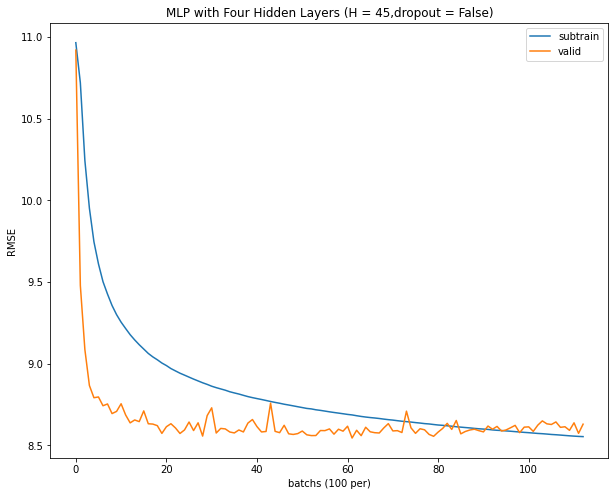

In [ ]:
Q2_model = MyMLP()
model = Q2_model.net(input_shape,output_shape,H,device,dropout=False)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
model = Q2_model.train(device,optimizer)
test_RMSE = Q2_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')
Q2_model.plot(H)

#### 討論訓練過程中Training與Validation RMSE的圖形意義

從以上圖表可知，Training RMSE不斷下降，Validation RMSE則大概到1500batch之後就不再下降而呈現上下不斷波動的情形，在9000batch之後甚至出現overfitting

#### 刪除資料集，釋放記憶體

In [ ]:
del X_subtrain, Y_subtrain
del X_valid, Y_valid
del X_train, Y_train
del X_test, Y_test

### Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

H = 90時，Test RMSE數值

In [ ]:
lr = 0.00001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H=90

Q3_model = MyMLP()
model = Q3_model.net(input_shape,output_shape,H,device)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
model = Q3_model.train(device,optimizer)
test_RMSE = Q3_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.909226417541504
Validation RMSE:10.817122459411621
Epoch:0 Batch:200
Training RMSE:10.583501815795898
Validation RMSE:9.232998847961426
Epoch:0 Batch:300
Training RMSE:10.252165794372559
Validation RMSE:9.03223991394043
Epoch:0 Batch:400
Training RMSE:10.030466079711914
Validation RMSE:8.970934867858887
Epoch:1 Batch:500
Training RMSE:9.899024963378906
Validation RMSE:8.928123474121094
Epoch:1 Batch:600
Training RMSE:9.795539855957031
Validation RMSE:8.973295211791992
Epoch:1 Batch:700
Training RMSE:9.707758903503418
Validation RMSE:8.910743713378906
Epoch:1 Batch:800
Training RMSE:9.63921070098877
Validation RMSE:8.879053115844727
Epoch:2 Batch:900
Training RMSE:9.585904121398926
Validation RMSE:8.878338813781738
Epoch:2 Batch:1000
Training RMSE:9.54293441772461
Validation RMSE:8.868816375732422
Epoch:2 Batch:1100
Training RMSE:9.50635814666748
Validation RMSE:8.865644454956055
Epoch:2 Batch:1200
Training RMSE:9.474724769592285
Validation RMSE:8.8327

H = 180時，Test RMSE數值

In [ ]:
lr = 0.00001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H=180

Q3_model = MyMLP()
model = Q3_model.net(input_shape,output_shape,H,device)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
model = Q3_model.train(device,optimizer)
test_RMSE = Q3_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.841863632202148
Validation RMSE:10.037274360656738
Epoch:0 Batch:200
Training RMSE:10.246490478515625
Validation RMSE:9.134331703186035
Epoch:0 Batch:300
Training RMSE:9.941608428955078
Validation RMSE:8.949620246887207
Epoch:0 Batch:400
Training RMSE:9.754101753234863
Validation RMSE:8.896788597106934
Epoch:1 Batch:500
Training RMSE:9.628193855285645
Validation RMSE:8.834697723388672
Epoch:1 Batch:600
Training RMSE:9.541803359985352
Validation RMSE:8.869587898254395
Epoch:1 Batch:700
Training RMSE:9.483091354370117
Validation RMSE:8.841927528381348
Epoch:1 Batch:800
Training RMSE:9.429625511169434
Validation RMSE:8.806578636169434
Epoch:2 Batch:900
Training RMSE:9.3860502243042
Validation RMSE:8.79455280303955
Epoch:2 Batch:1000
Training RMSE:9.345904350280762
Validation RMSE:8.749462127685547
Epoch:2 Batch:1100
Training RMSE:9.315070152282715
Validation RMSE:8.738259315490723
Epoch:2 Batch:1200
Training RMSE:9.28564167022705
Validation RMSE:8.731098

#### 討論H = 45, 90, 180的Test RMSE

在H=180下擁有最好的損失函數，推測原因H=180時擁有最多的neuron，模型經過比較多層的訓練因此擁有最好的預測結果，而在Test RMSE的表現上H=180也表現的最好，但與H=90相差甚少，因此模型可能已經接近local minimum，隨著神經網路增加預測結果只好一點點

### Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

In [ ]:
H_list = [45, 90, 180]
weight_list = [0.1, 0.2, 0.4]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.00001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1

for H in H_list:
    for weight in weight_list:
        Q4_model = MyMLP()
        model = Q4_model.net(input_shape, output_shape,H,device)
        optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight)
        print(f'Q4MLP(H={H} weight decay ={weight}) is training')
        model = Q4_model.train(device, optimizer,verbose=False)
        test_RMSE = Q4_model.test(device, testloader)
        print(f'when H = {H}, weight decay = {weight}, test_RMSE = {test_RMSE}')  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


============Early Stop==================
best step:5600 best loss:8.558300971984863
when H = 45, weight decay = 0.1, test_RMSE = 8.884754180908203
============Early Stop==================
best step:3700 best loss:8.544100761413574
when H = 45, weight decay = 0.2, test_RMSE = 9.009414672851562
============Early Stop==================
best step:4200 best loss:8.558541297912598
when H = 45, weight decay = 0.4, test_RMSE = 8.895747184753418
============Early Stop==================
best step:4500 best loss:8.500055313110352
when H = 90, weight decay = 0.1, test_RMSE = 8.944291114807129
============Early Stop==================
best step:4600 best loss:8.525056838989258
when H = 90, weight decay = 0.2, test_RMSE = 9.219419479370117
============Early Stop==================
best step:4000 best loss:8.500831604003906
when H = 90, weight decay = 0.4, test_RMSE = 8.974624633789062
============Early Stop==================
best step:4000 best loss:8.465256690979004
when H = 180, weight decay = 0.1, 

#### 討論H的選擇應為多少較合理?

從以上結果可知，隨著H增加，test_RMSE呈現上升趨勢，由此可知過複雜的模型造成overfitting，因此以上最好的結果是when H = 45, weight decay = 0.1, test_RMSE = 8.884754180908203

### Q5 MLP with Dropout (15%)
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.496915817260742
Validation RMSE:9.441896438598633
Epoch:0 Batch:200
Training RMSE:10.043078422546387
Validation RMSE:9.104605674743652
Epoch:0 Batch:300
Training RMSE:9.833292007446289
Validation RMSE:8.978920936584473
Epoch:0 Batch:400
Training RMSE:9.697859764099121
Validation RMSE:8.935309410095215
Epoch:1 Batch:500
Training RMSE:9.602527618408203
Validation RMSE:8.905191421508789
Epoch:1 Batch:600
Training RMSE:9.532760620117188
Validation RMSE:8.847739219665527
Epoch:1 Batch:700
Training RMSE:9.479829788208008
Validation RMSE:8.812065124511719
Epoch:1 Batch:800
Training RMSE:9.434534072875977
Validation RMSE:8.811443328857422
Epoch:2 Batch:900
Training RMSE:9.398612976074219
Validation RMSE:8.78073787689209
Epoch:2 Batch:1000
Training RMSE:9.366822242736816
Validation RMSE:8.785164833068848
Epoch:2 Batch:1100
Training RMSE:9.3421630859375
Validation RMSE:8.784465789794922
Epoch:2 Batch:1200
Training RMSE:9.321125984191895
Validation RMSE:8.806420

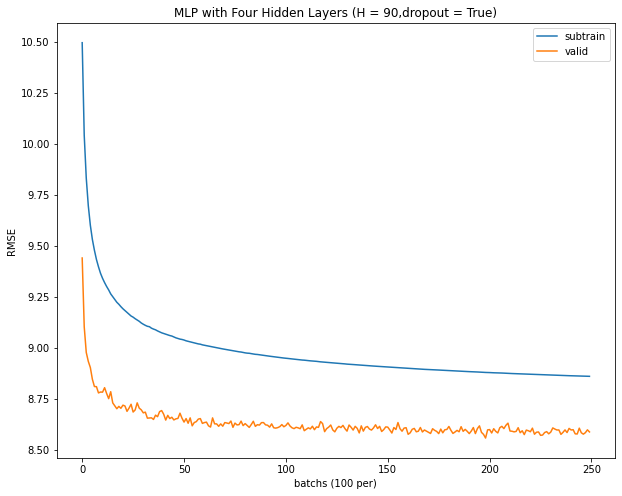

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 90


Q5_model = MyMLP()
model = Q5_model.net(input_shape,output_shape,H,device,dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model = Q5_model.train(device,optimizer)
test_RMSE = Q5_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')
Q5_model.plot(H,True)

### 討論訓練過程中Training與Validation RMSE的圖形意義

與前面圖形相比，很明顯有加入Dropout，batch後半段不再出現overfitting，因為Dropout只留下一半的feature來產生output，會導致留下來的feature對output影響結果更強。等到進入validation階段的時候，全部的neuron一起運作就會讓output的結果更好(error更小)

### Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

H = 20時，Test RMSE數值

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 20

Q6_model = MyMLP()
model = Q6_model.net(input_shape,output_shape,H,device,dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model = Q6_model.train(device,optimizer)
test_RMSE = Q6_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.914627075195312
Validation RMSE:10.66990852355957
Epoch:0 Batch:200
Training RMSE:10.686294555664062
Validation RMSE:9.773836135864258
Epoch:0 Batch:300
Training RMSE:10.461749076843262
Validation RMSE:9.514527320861816
Epoch:0 Batch:400
Training RMSE:10.30649185180664
Validation RMSE:9.35497760772705
Epoch:1 Batch:500
Training RMSE:10.190840721130371
Validation RMSE:9.269824981689453
Epoch:1 Batch:600
Training RMSE:10.108076095581055
Validation RMSE:9.243973731994629
Epoch:1 Batch:700
Training RMSE:10.050711631774902
Validation RMSE:9.194318771362305
Epoch:1 Batch:800
Training RMSE:9.99825668334961
Validation RMSE:9.173192024230957
Epoch:2 Batch:900
Training RMSE:9.949224472045898
Validation RMSE:9.146329879760742
Epoch:2 Batch:1000
Training RMSE:9.914420127868652
Validation RMSE:9.12095832824707
Epoch:2 Batch:1100
Training RMSE:9.879379272460938
Validation RMSE:9.138766288757324
Epoch:2 Batch:1200
Training RMSE:9.855792999267578
Validation RMSE:9.13

H = 45時，Test RMSE數值

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 45

Q6_model = MyMLP()
model = Q6_model.net(input_shape,output_shape,H,device,dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model = Q6_model.train(device,optimizer)
test_RMSE = Q6_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.689420700073242
Validation RMSE:9.80948257446289
Epoch:0 Batch:200
Training RMSE:10.279781341552734
Validation RMSE:9.320520401000977
Epoch:0 Batch:300
Training RMSE:10.049967765808105
Validation RMSE:9.13329792022705
Epoch:0 Batch:400
Training RMSE:9.915108680725098
Validation RMSE:9.097502708435059
Epoch:1 Batch:500
Training RMSE:9.81801986694336
Validation RMSE:9.017497062683105
Epoch:1 Batch:600
Training RMSE:9.746317863464355
Validation RMSE:8.994589805603027
Epoch:1 Batch:700
Training RMSE:9.69255256652832
Validation RMSE:8.974111557006836
Epoch:1 Batch:800
Training RMSE:9.646522521972656
Validation RMSE:8.937273025512695
Epoch:2 Batch:900
Training RMSE:9.604504585266113
Validation RMSE:8.917245864868164
Epoch:2 Batch:1000
Training RMSE:9.575363159179688
Validation RMSE:8.915721893310547
Epoch:2 Batch:1100
Training RMSE:9.54417610168457
Validation RMSE:8.928070068359375
Epoch:2 Batch:1200
Training RMSE:9.520062446594238
Validation RMSE:8.8907270

H = 180時，Test RMSE數值

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 180

Q6_model = MyMLP()
model = Q6_model.net(input_shape,output_shape,H,device,dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model = Q6_model.train(device,optimizer)
test_RMSE = Q6_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.20142650604248
Validation RMSE:9.26504898071289
Epoch:0 Batch:200
Training RMSE:9.790473937988281
Validation RMSE:8.989136695861816
Epoch:0 Batch:300
Training RMSE:9.616174697875977
Validation RMSE:8.885553359985352
Epoch:0 Batch:400
Training RMSE:9.496101379394531
Validation RMSE:8.8313570022583
Epoch:1 Batch:500
Training RMSE:9.411355972290039
Validation RMSE:8.837593078613281
Epoch:1 Batch:600
Training RMSE:9.356754302978516
Validation RMSE:8.81417465209961
Epoch:1 Batch:700
Training RMSE:9.310369491577148
Validation RMSE:8.816288948059082
Epoch:1 Batch:800
Training RMSE:9.274052619934082
Validation RMSE:8.74799633026123
Epoch:2 Batch:900
Training RMSE:9.24262523651123
Validation RMSE:8.756890296936035
Epoch:2 Batch:1000
Training RMSE:9.216052055358887
Validation RMSE:8.731582641601562
Epoch:2 Batch:1100
Training RMSE:9.194977760314941
Validation RMSE:8.720885276794434
Epoch:2 Batch:1200
Training RMSE:9.170372009277344
Validation RMSE:8.70049762725

H = 360時，Test RMSE數值

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 360

Q6_model = MyMLP()
model = Q6_model.net(input_shape,output_shape,H,device,dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model = Q6_model.train(device,optimizer)
test_RMSE = Q6_model.test(device,testloader)
print(f'H = {H} Test_RMSE = {test_RMSE}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:9.93531608581543
Validation RMSE:9.108758926391602
Epoch:0 Batch:200
Training RMSE:9.599625587463379
Validation RMSE:8.979246139526367
Epoch:0 Batch:300
Training RMSE:9.462857246398926
Validation RMSE:8.857792854309082
Epoch:0 Batch:400
Training RMSE:9.378317832946777
Validation RMSE:8.845174789428711
Epoch:1 Batch:500
Training RMSE:9.306299209594727
Validation RMSE:8.800986289978027
Epoch:1 Batch:600
Training RMSE:9.250448226928711
Validation RMSE:8.762139320373535
Epoch:1 Batch:700
Training RMSE:9.207507133483887
Validation RMSE:8.804971694946289
Epoch:1 Batch:800
Training RMSE:9.17929458618164
Validation RMSE:8.704842567443848
Epoch:2 Batch:900
Training RMSE:9.148954391479492
Validation RMSE:8.658984184265137
Epoch:2 Batch:1000
Training RMSE:9.120766639709473
Validation RMSE:8.669395446777344
Epoch:2 Batch:1100
Training RMSE:9.096237182617188
Validation RMSE:8.706174850463867
Epoch:2 Batch:1200
Training RMSE:9.078707695007324
Validation RMSE:8.6593799

### 討論H = 20, 45, 180, 360的Test RMSE

在使用Dropout和Adam演算法之後，模型不再出現overfitting， 然而H 最大的時候，並不是 RMSE 最小、預測能力最好的時候。是剛好介在中間的 H = 180 得到了最好的成績。

### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [ ]:
class Q7MLP(MyMLP):
    def __init__(self,z):
        super().__init__()
        self.z = z
   
    def loss(self,y_pred,y_true):
        Q7loss = self.z*(((y_pred-y_true)**2).sum())+(1-self.z)*((torch.abs(y_pred-y_true)).sum())
        return Q7loss
    
    def train(self,device,optimizer,verbose=True):
        step_count = 0
        total_loss = 0
        for epoch_idx in range(self.epoch):
            for batch_idx, (inputs, targets) in enumerate(subtrainloader):
                targets = targets.reshape((-1, 1))
                self.model.train()
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                step_count += 1
                outputs = self.model(inputs)
                loss = self.loss(outputs,targets)
                loss_SSE = self.sse(outputs, targets)
                loss_MSE = self.mse(outputs,targets)
                loss.backward()
                optimizer.step()
                total_loss += loss_MSE
                if step_count % self.calc_rmse_intvls == 0:
                    rmse_train = ((total_loss / step_count)**0.5).cpu().detach().numpy()
                    rmse_valid =self.calc_rmse(device,validloader,self.model).cpu().detach().numpy()
                    self.train_rmse_lst.append(rmse_train)
                    self.valid_rmse_lst.append(rmse_valid)
                    if verbose:
                      print(f'Epoch:{epoch_idx} Batch:{step_count}')
                      print(f'Training RMSE:{rmse_train}')
                      print(f'Validation RMSE:{rmse_valid}')
                      print('=====================================')
                      #total_loss = 0
                    if rmse_valid < self.best_loss:
                        self.best_loss = rmse_valid
                        self.best_step_count = step_count
                        self.best_model = self.model 
                    elif step_count - self.best_step_count > self.patience:
                        self.end_step = step_count
                        print('============Early Stop==================')
                        print(f'best step:{self.best_step_count} best loss:{self.best_loss}')
                        return self.best_model  
        self.end_step = step_count
        return self.best_model
    
    def plot(self,H,dropout=False):
        plt.figure(figsize=(10,8))
        plt.plot(self.train_rmse_lst, label='subtrain')
        plt.plot(self.valid_rmse_lst, label='valid')
        plt.title(f'MLP with Four Hidden Layers and L2+L1 Loss (H = {H}, z = {self.z}, dropout = {dropout})')
        plt.xlabel('batchs (100 per)')
        plt.ylabel('RMSE')
        plt.legend(loc='best')
        plt.show()

畫出Training and Validation RMSE，並報告Test RMSE

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.502344131469727
Validation RMSE:9.456080436706543
Epoch:0 Batch:200
Training RMSE:10.051857948303223
Validation RMSE:9.094910621643066
Epoch:0 Batch:300
Training RMSE:9.834074020385742
Validation RMSE:9.027044296264648
Epoch:0 Batch:400
Training RMSE:9.69693374633789
Validation RMSE:8.91567325592041
Epoch:1 Batch:500
Training RMSE:9.5947847366333
Validation RMSE:8.894513130187988
Epoch:1 Batch:600
Training RMSE:9.522619247436523
Validation RMSE:8.861030578613281
Epoch:1 Batch:700
Training RMSE:9.474925994873047
Validation RMSE:8.843263626098633
Epoch:1 Batch:800
Training RMSE:9.433830261230469
Validation RMSE:8.798746109008789
Epoch:2 Batch:900
Training RMSE:9.394797325134277
Validation RMSE:8.815794944763184
Epoch:2 Batch:1000
Training RMSE:9.366596221923828
Validation RMSE:8.804056167602539
Epoch:2 Batch:1100
Training RMSE:9.340600967407227
Validation RMSE:8.768866539001465
Epoch:2 Batch:1200
Training RMSE:9.316764831542969
Validation RMSE:8.7559471

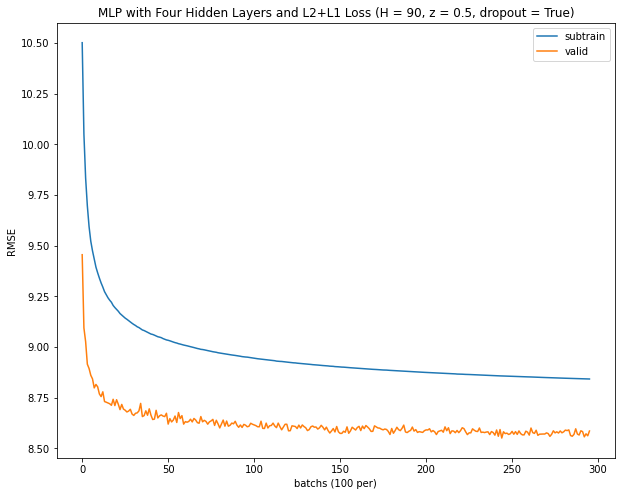

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 90
z=0.5

Q7_model = Q7MLP(z)
model = Q7_model.net(input_shape,output_shape,H,device,dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model = Q7_model.train(device,optimizer,True)
Q7test_RMSE = Q7_model.test(device,testloader)
print(f'H = {H} z ={z} Test_RMSE = {Q7test_RMSE}')
Q7_model.plot(H,True)

使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_list = [0.0, 0.1, 0.5, 0.9, 1.0]
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 90
z=0.5

for z in z_list:
    Q7_model = Q7MLP(z)
    model = Q7_model.net(input_shape,output_shape,H,device,dropout=True)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    print(f'Q7MLP(H={H} z ={z}) is training')
    model = Q7_model.train(device,optimizer,verbose=False)
    test_RMSE = Q7_model.test(device,testloader)
    print(f'H = {H} z ={z} Test_RMSE = {test_RMSE}')
    print('===============================================')

Q7MLP(H=90 z =0.0) is training


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


============Early Stop==================
best step:12300 best loss:8.851669311523438
H = 90 z =0.0 Test_RMSE = 9.015715599060059
Q7MLP(H=90 z =0.1) is training
============Early Stop==================
best step:25800 best loss:8.5739107131958
H = 90 z =0.1 Test_RMSE = 8.770198822021484
Q7MLP(H=90 z =0.5) is training
============Early Stop==================
best step:15500 best loss:8.569818496704102
H = 90 z =0.5 Test_RMSE = 8.768113136291504
Q7MLP(H=90 z =0.9) is training
============Early Stop==================
best step:17200 best loss:8.57918643951416
H = 90 z =0.9 Test_RMSE = 8.7907075881958
Q7MLP(H=90 z =1.0) is training
============Early Stop==================
best step:12200 best loss:8.566431045532227
H = 90 z =1.0 Test_RMSE = 8.776327133178711


### 統整各個z值下的Test RMSE並討論

從以上結果可知在z=0.5時擁有最好的預測結果(最小的Test_RMSE)，而不是最大的z=1.0，然而我們還是可以從中看出這個模型L2與L1配飾程度相當，因為L2比例最好的時候佔了五成。

### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [ ]:
class Q8MLP(Q7MLP):
    def __init__(self,z,q):
        super().__init__(z)
        self.q = q
        
    def loss(self,y_pred,y_true):
        relu = nn.ReLU()
        qloss = (self.q*relu(y_pred-y_true)+(1-self.q)*relu(y_true-y_pred)).sum()
        loss = self.z*(((y_pred-y_true)**2).sum())+(1-self.z)*qloss
        return loss
    
    def plot(self,H,dropout=False):
        plt.figure(figsize=(10,8))
        plt.plot(self.train_rmse_lst, label='subtrain')
        plt.plot(self.valid_rmse_lst, label='valid')
        plt.title(f' MLP with Four Hidden Layers and L2 + customerized Loss (H = {H}, z = {self.z}, dropout = {dropout})')
        plt.xlabel('batchs (100 per)')
        plt.ylabel('RMSE')
        plt.legend(loc='best')
        plt.show()

畫出Training and Validation RMSE，並報告Test RMSE

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:0 Batch:100
Training RMSE:10.926386833190918
Validation RMSE:10.531264305114746
Epoch:0 Batch:200
Training RMSE:10.75102424621582
Validation RMSE:10.034151077270508
Epoch:0 Batch:300
Training RMSE:10.492703437805176
Validation RMSE:9.386927604675293
Epoch:0 Batch:400
Training RMSE:10.284648895263672
Validation RMSE:9.282980918884277
Epoch:1 Batch:500
Training RMSE:10.16113567352295
Validation RMSE:9.228525161743164
Epoch:1 Batch:600
Training RMSE:10.065363883972168
Validation RMSE:9.133197784423828
Epoch:1 Batch:700
Training RMSE:9.996522903442383
Validation RMSE:9.075819969177246
Epoch:1 Batch:800
Training RMSE:9.915518760681152
Validation RMSE:9.060595512390137
Epoch:2 Batch:900
Training RMSE:9.863781929016113
Validation RMSE:9.083978652954102
Epoch:2 Batch:1000
Training RMSE:9.820226669311523
Validation RMSE:9.099539756774902
Epoch:2 Batch:1100
Training RMSE:9.776508331298828
Validation RMSE:9.05945110321045
Epoch:2 Batch:1200
Training RMSE:9.748570442199707
Validation RMSE:9.

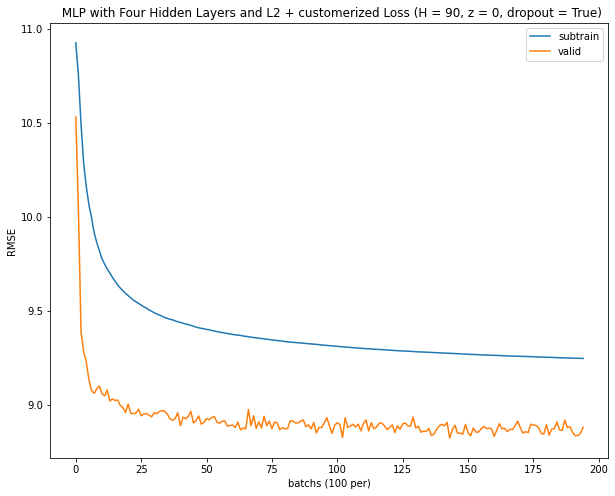

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]
output_shape = 1
H = 90
z=0
q=0.5

Q8_model = Q8MLP(z,q)
model = Q8_model.net(input_shape,output_shape,H,device,dropout=True)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model = Q8_model.train(device,optimizer,verbose=True)
Q8test_RMSE = Q8_model.test(device,testloader)
print(f'H = {H} z ={z} Test_RMSE = {Q8test_RMSE}')
Q8_model.plot(H,dropout=True)

使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論

In [ ]:
z_list = [0.0, 0.1, 0.5, 0.9, 1.0]
q = 0.5

for z in z_list:
    Q8_model = Q8MLP(z,q)
    model = Q8_model.net(input_shape,output_shape,H,device,dropout=True)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    print(f'Q8MLP(H={H} z ={z}) is training')
    model = Q8_model.train(device,optimizer,verbose=False)
    test_RMSE = Q8_model.test(device,testloader)
    print(f'H = {H} z ={z} Test_RMSE = {test_RMSE}')

Q8MLP(H=90 z =0.0) is training


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


============Early Stop==================
best step:9800 best loss:8.875958442687988
H = 90 z =0.0 Test_RMSE = 8.97962760925293
Q8MLP(H=90 z =0.1) is training
============Early Stop==================
best step:17000 best loss:8.56253433227539
H = 90 z =0.1 Test_RMSE = 8.795825958251953
Q8MLP(H=90 z =0.5) is training
============Early Stop==================
best step:17700 best loss:8.576507568359375
H = 90 z =0.5 Test_RMSE = 8.787635803222656
Q8MLP(H=90 z =0.9) is training
============Early Stop==================
best step:17800 best loss:8.569211959838867
H = 90 z =0.9 Test_RMSE = 8.78547477722168
Q8MLP(H=90 z =1.0) is training
============Early Stop==================
best step:19400 best loss:8.563044548034668
H = 90 z =1.0 Test_RMSE = 8.780756950378418


### 統整各個z值下的Test RMSE並討論

，從以上結果我們可以看出隨著z變大，Test_RMSE呈現下降趨勢，z 的值越大，代表 L2 Loss 的佔比越大，因此我們可以推估 L2 Loss 較適合這個情境，故在z=1.0時有較好的表現。